In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.signal import find_peaks

from itertools import groupby
from operator import itemgetter

import torch
from pipeline import AnomalyDetectionPipeline
import preprocessing as prep
import machine_learning as ml

In [14]:
data = 'data/TOTF.PA-book/2015-01-02-TOTF.PA-book.csv.gz'
lobster_ob = "data/LOBSTER/AMZN_2012-06-21_34200000_57600000_orderbook_10.csv"
lobster_msg = "data/LOBSTER/AMZN_2012-06-21_34200000_57600000_message_10.csv"

In [15]:
# Initialize Pipeline
pipeline = AnomalyDetectionPipeline(seq_length=25, batch_size=128)

# Load Data
nrows = 100_000
try:
    df_lobster = prep.load_lobster_data(orderbook_path=lobster_ob, message_path=lobster_msg, levels=10, nrows=nrows)
    pipeline.raw_df = df_lobster
except Exception as e:
    print(f"Error loading data: {e}")

# pipeline.load_data(data, nrows=nrows)

# Engineer Features
selected_features = ['base', 'tao', 'hawkes', 'poutre', 'ofi']
pipeline.engineer_features(feature_sets=selected_features)

# Preprocess Data
pipeline.scale_and_sequence(method='box-cox', train_split=0.7)

Pipeline initialized on device: cuda
Loading LOBSTER data from data/LOBSTER/AMZN_2012-06-21_34200000_57600000_orderbook_10.csv...
Successfully loaded 100000 LOBSTER rows.
Engineering features: ['base', 'tao', 'hawkes', 'poutre', 'ofi']...
Feature Engineering complete. Total features: 121
Preprocessing with method: box-cox...
Dropping 12 constant/zero-variance features: ['Hawkes_L_ask_beta100_Eta1.0', 'Hawkes_L_ask_beta1000_Eta10.0', 'Hawkes_L_bid_beta10_Eta1.0', 'Hawkes_L_bid_beta1000_Eta1.0', 'Hawkes_L_bid_beta100_Eta1.0', 'Hawkes_L_ask_beta100_Eta10.0', 'Hawkes_L_ask_beta10_Eta1.0', 'Hawkes_L_ask_beta1000_Eta1.0', 'Hawkes_L_bid_beta1000_Eta10.0', 'Hawkes_L_ask_beta10_Eta10.0', 'Hawkes_L_bid_beta10_Eta10.0', 'Hawkes_L_bid_beta100_Eta10.0']
Data split: Train (69982, 25, 109), Test (29993, 25, 109)


In [16]:
# Train Transformer + OC-SVM Model
pipeline.train_model(
    model_type='transformer_ocsvm', 
    epochs=20, 
    lr=1e-3,
    nu=0.01
)

Initializing Transformer Autoencoder...
Training Autoencoder...
Epoch 1/20 - Loss: 0.535781
Epoch 2/20 - Loss: 0.282999
Epoch 3/20 - Loss: 0.188793
Epoch 4/20 - Loss: 0.150100
Epoch 5/20 - Loss: 0.130027
Epoch 6/20 - Loss: 0.116753
Epoch 7/20 - Loss: 0.107460
Epoch 8/20 - Loss: 0.100863
Epoch 9/20 - Loss: 0.095939
Epoch 10/20 - Loss: 0.092072
Epoch 11/20 - Loss: 0.089096
Epoch 12/20 - Loss: 0.086799
Epoch 13/20 - Loss: 0.084802
Epoch 14/20 - Loss: 0.083164
Epoch 15/20 - Loss: 0.081786
Epoch 16/20 - Loss: 0.080453
Epoch 17/20 - Loss: 0.079388
Epoch 18/20 - Loss: 0.078369
Epoch 19/20 - Loss: 0.077466
Epoch 20/20 - Loss: 0.076650
Extracting Latent Representations for OC-SVM...
Training One-Class SVM (nu=0.01)...


Detected 300 anomalies in test set.


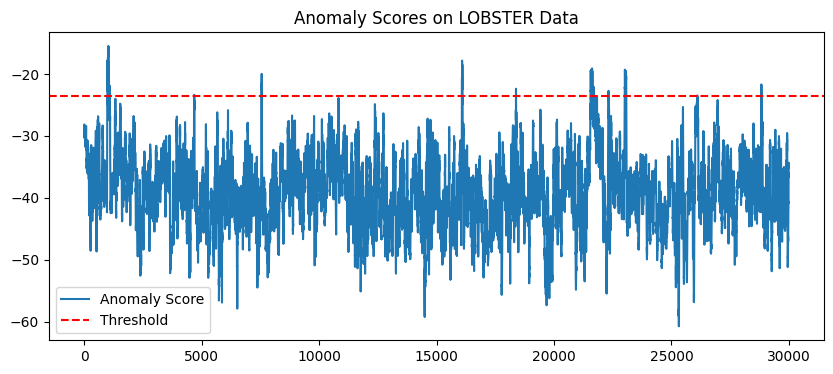

In [17]:
# Scan for anomalies using Transformer + OC-SVM
z_test = pipeline._get_latent(pipeline.X_test)
z_test_scaled = pipeline.latent_scaler.transform(z_test)
anomaly_scores = - pipeline.detector.score_samples(z_test_scaled) # Higher = more anomalous

threshold = np.percentile(anomaly_scores, 99)  # 99th percentile
anomalies_idx = np.where(anomaly_scores > threshold)[0]
print(f"Detected {len(anomalies_idx)} anomalies in test set.")

plt.figure(figsize=(10, 4))
plt.plot(anomaly_scores, label='Anomaly Score')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Anomaly Scores on LOBSTER Data')
plt.legend()
plt.show()

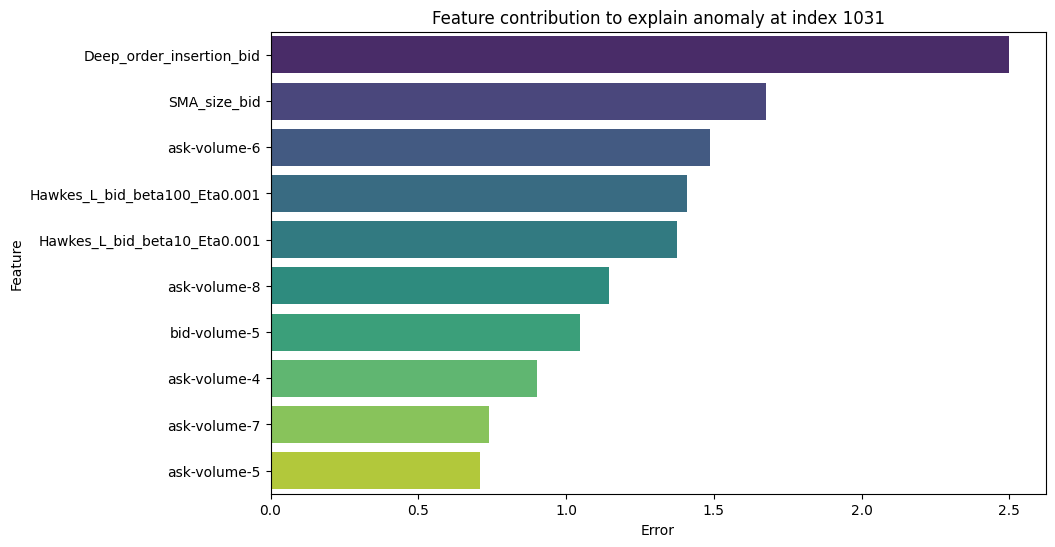

In [18]:
# Get the top anomaly index
top_anomaly_idx = anomalies_idx[np.argmax(anomaly_scores[anomalies_idx])]

# Get Input and Reconstructed Output for that specific sequence
seq_tensor = torch.tensor(pipeline.X_test[top_anomaly_idx]).unsqueeze(0).to(pipeline.device).float()

pipeline.model.eval()
with torch.no_grad():
    reconstructed_seq = pipeline.model(seq_tensor).cpu().numpy().squeeze()

input_seq = pipeline.X_test[top_anomaly_idx]

# Calculate Squared Error per feature (Mean over the sequence time dimension)
feature_errors = np.mean((input_seq - reconstructed_seq) ** 2, axis=0)

# Plot top 10 contributors to anomaly
feat_error_df = pd.DataFrame({
    'Feature': pipeline.feature_names,
    'Error': feature_errors
}).sort_values(by='Error', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_error_df, x='Error', y='Feature', hue='Feature', palette='viridis')
plt.title(f"Feature contribution to explain anomaly at index {top_anomaly_idx}")
plt.show()

Found 19 peaks above threshold.
Annotating peaks with most anomalous feature...
Peak at index 989 annotated with feature 'ask-volume-5'.
Peak at index 1011 annotated with feature 'ask-volume-8'.
Peak at index 1031 annotated with feature 'Deep_order_insertion_bid'.
Peak at index 1053 annotated with feature 'Deep_order_insertion_bid'.
Peak at index 1089 annotated with feature 'Hawkes_L_bid_beta100_Eta0.001'.
Peak at index 4685 annotated with feature 'bid_sweep_cost'.
Peak at index 7555 annotated with feature 'bid-volume-5'.
Peak at index 16086 annotated with feature 'ask_price_speed'.
Peak at index 18381 annotated with feature 'bid-volume-7'.
Peak at index 21562 annotated with feature 'Hawkes_L_bid_beta10_Eta0.001'.
Peak at index 21599 annotated with feature 'Hawkes_L_bid_beta100_Eta0.001'.
Peak at index 21620 annotated with feature 'Hawkes_L_bid_beta100_Eta0.001'.
Peak at index 21643 annotated with feature 'Hawkes_L_bid_beta100_Eta0.001'.
Peak at index 21692 annotated with feature 'Hawk

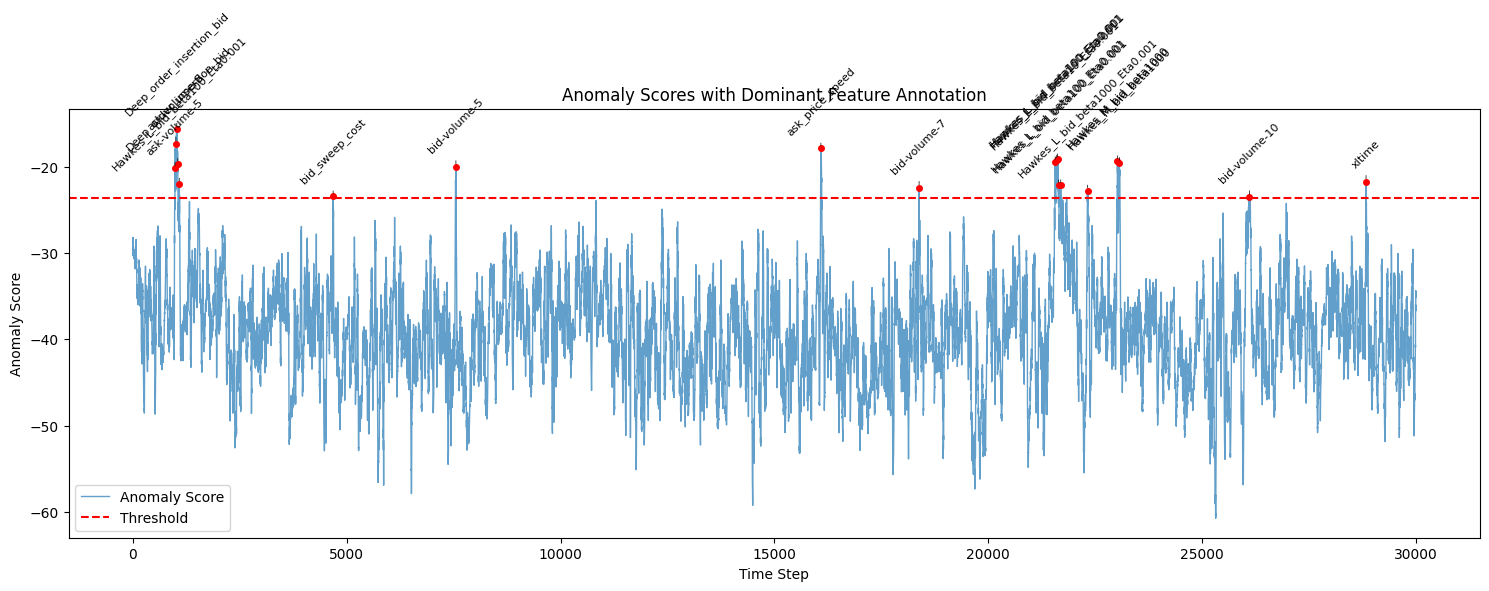

In [19]:
# Find peaks in the anomaly score
# distance=20 prevents detecting adjacent points as separate peaks
peaks, _ = find_peaks(anomaly_scores, height=threshold, distance=20)
print(f"Found {len(peaks)} peaks above threshold.")

plt.figure(figsize=(15, 6))
plt.plot(anomaly_scores, label='Anomaly Score', color='#1f77b4', linewidth=1, alpha=0.7)
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')


pipeline.model.eval()

print("Annotating peaks with most anomalous feature...")
for peak_idx in peaks:
    # Get sequence tensor
    seq_tensor = torch.tensor(pipeline.X_test[peak_idx]).unsqueeze(0).to(pipeline.device).float()
    
    # Reconstruct
    with torch.no_grad():
        reconstructed_seq = pipeline.model(seq_tensor).cpu().numpy().squeeze()
        
    input_seq = pipeline.X_test[peak_idx]
    
    # Compute error per feature
    feature_errors = np.mean((input_seq - reconstructed_seq) ** 2, axis=0)
    
    # Find feature with max error
    max_error_idx = np.argmax(feature_errors)
    max_feature_name = pipeline.feature_names[max_error_idx]
    
    # Plot point
    score = anomaly_scores[peak_idx]
    plt.plot(peak_idx, score, 'ro', markersize=4)
    
    # Annotate with feature name
    plt.annotate(max_feature_name, 
                 xy=(peak_idx, score), 
                 xytext=(0, 10), 
                 textcoords='offset points',
                 ha='center', 
                 fontsize=8,
                 rotation=45,
                 arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
    
    print(f"Peak at index {peak_idx} annotated with feature '{max_feature_name}'.")

plt.title('Anomaly Scores with Dominant Feature Annotation')
plt.xlabel('Time Step')
plt.ylabel('Anomaly Score')
plt.legend()
plt.tight_layout()
plt.show()

Computing latent representations...
Analyzing 300 anomalies against 29693 normal samples.


C:\Users\adoni\AppData\Local\Temp\ipykernel_24936\3807555491.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=impact_df, x='Impact_Score', y='Feature', palette='viridis')


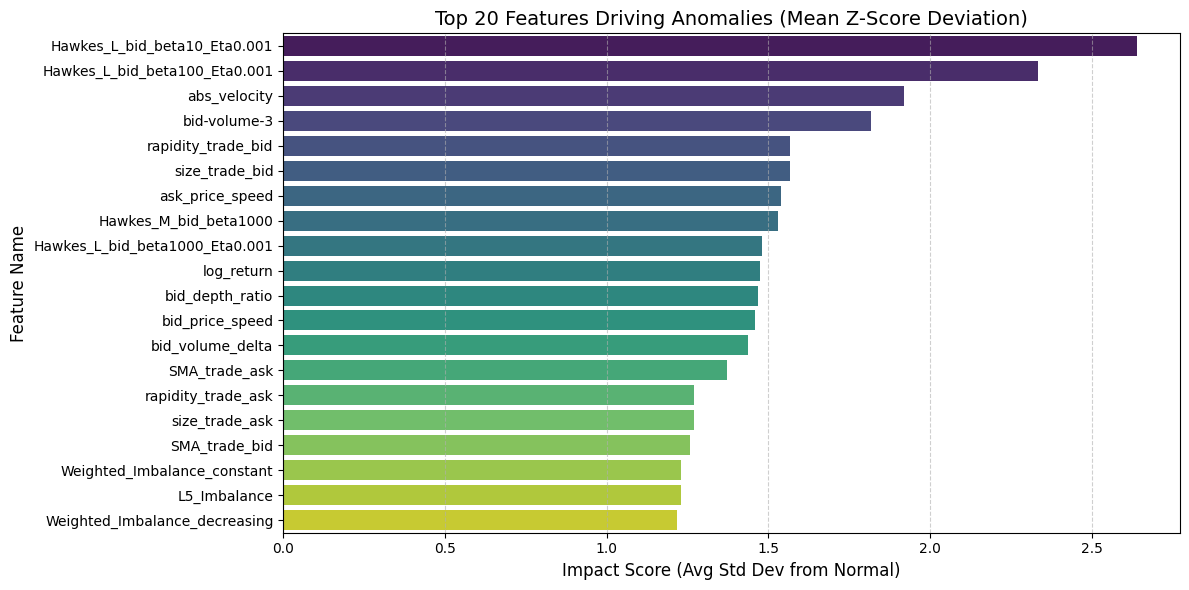

In [20]:
def analyze_anomaly_features(pipeline, percentile=99, top_n=15):
    """
    Identifies and plots the most significant features contributing to anomalies
    by calculating the deviation (Z-score) of anomalies from normal data.
    """
    print("Computing latent representations...")
    # Get Anomaly Scores
    z_test = pipeline._get_latent(pipeline.X_test)
    z_test_scaled = pipeline.latent_scaler.transform(z_test)
    scores = -pipeline.detector.score_samples(z_test_scaled) # High score = Anomaly

    # Identify Peak Anomalies vs Normal Baseline
    threshold = np.percentile(scores, percentile)
    anomaly_mask = scores > threshold
    
    X_anom = pipeline.X_test[anomaly_mask]
    X_normal = pipeline.X_test[~anomaly_mask]
    
    print(f"Analyzing {len(X_anom)} anomalies against {len(X_normal)} normal samples.")

    if len(X_anom) == 0:
        print("No anomalies found above threshold.")
        return

    # Calculate Statistics on Normal Data
    normal_mean = np.mean(X_normal, axis=0)
    normal_std = np.std(X_normal, axis=0)
    normal_std[normal_std < 1e-9] = 1e-9

    # Compute Deviation (Z-Score) for Anomalies
    z_scores = (X_anom - normal_mean) / normal_std
    abs_z_scores = np.abs(z_scores)

    # Aggregate Impact Scores
    # Average across all anomalous samples (axis 0) and sequence length (axis 1)
    # This gives us one impact score per feature
    feature_impact = np.mean(abs_z_scores, axis=(0, 1))

    # Organize Data
    impact_df = pd.DataFrame({
        'Feature': pipeline.feature_names,
        'Impact_Score': feature_impact
    })
    
    impact_df = impact_df.sort_values('Impact_Score', ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(data=impact_df, x='Impact_Score', y='Feature', palette='viridis')
    plt.title(f'Top {top_n} Features Driving Anomalies (Mean Z-Score Deviation)', fontsize=14)
    plt.xlabel('Impact Score (Avg Std Dev from Normal)', fontsize=12)
    plt.ylabel('Feature Name', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
    return impact_df

top_features = analyze_anomaly_features(pipeline, percentile=99, top_n=20)

Calculating Global Permutation Importance
Calculating Feature Importance (Permutation)...


C:\Users\adoni\AppData\Local\Temp\ipykernel_24936\2319329737.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Calculating Anomaly Deviation Impact


C:\Users\adoni\AppData\Local\Temp\ipykernel_24936\2319329737.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


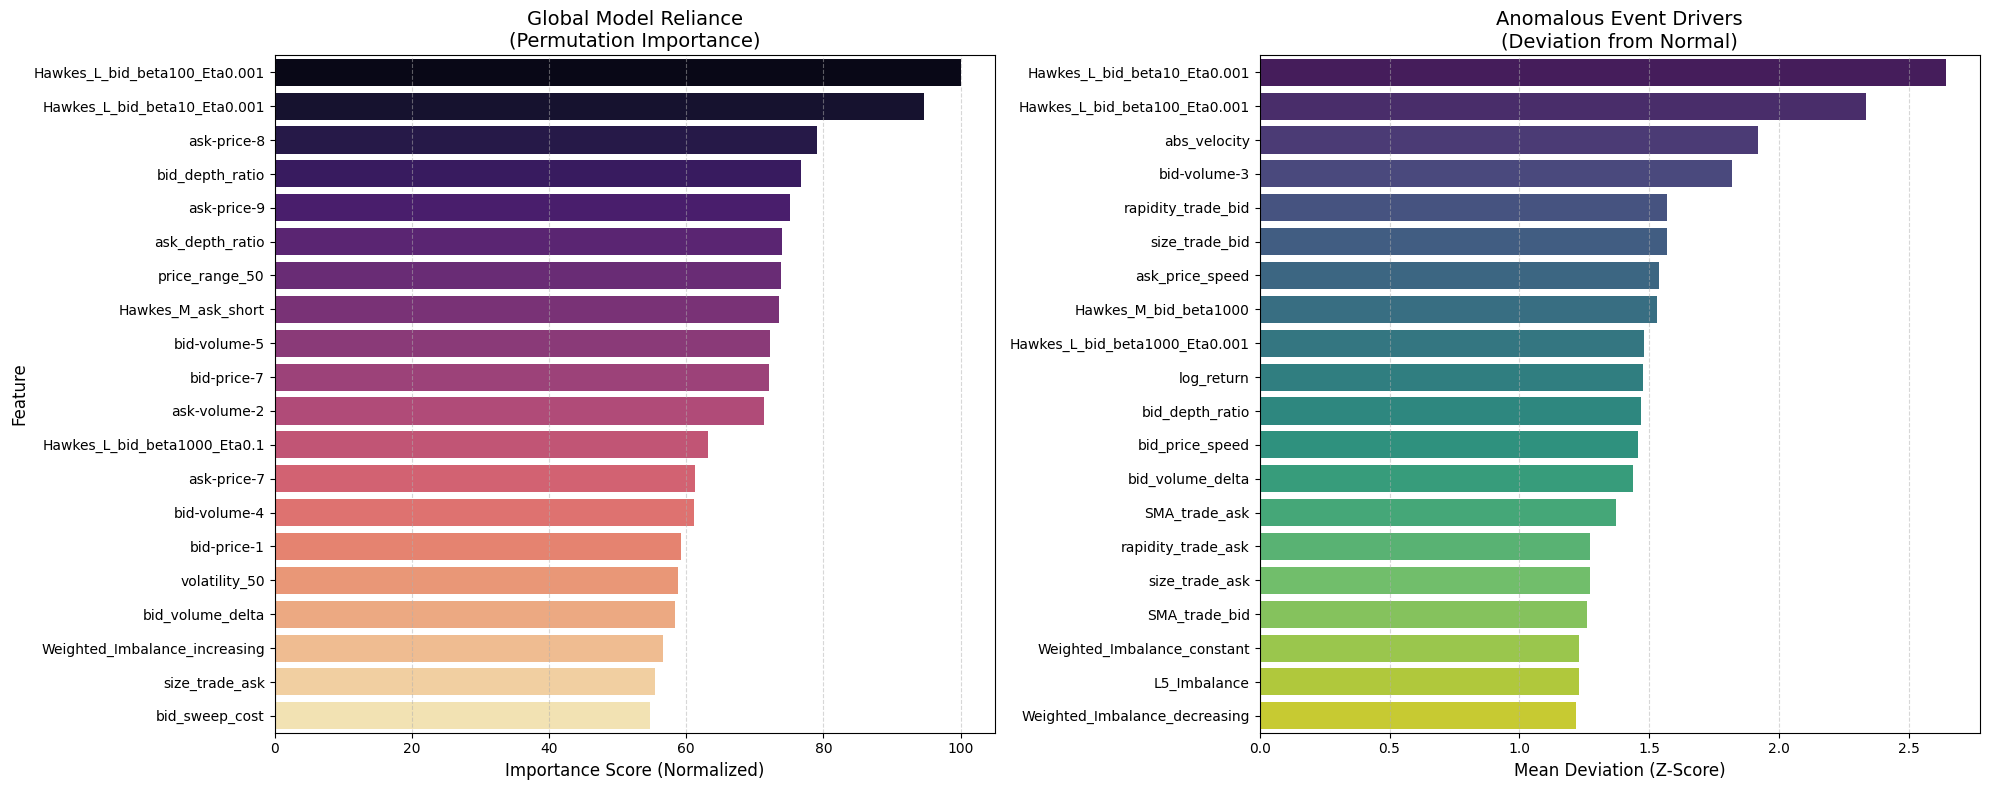

In [21]:
def plot_importance_vs_impact(pipeline, top_n=15, n_repeats=3, percentile=99):
    """
    Plots Permutation Importance (Global) vs. Anomaly Deviation (Local/Event-Specific)
    side by side.
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Global Feature Importance (Permutation)
    print("Calculating Global Permutation Importance")
    global_imp_df = pipeline.get_feature_importance(n_repeats=n_repeats)
    
    # Select top N for plotting
    top_global = global_imp_df.head(top_n)
    
    sns.barplot(
        data=top_global, 
        x='Importance', 
        y='Feature', 
        ax=axes[0], 
        palette='magma'
    )
    axes[0].set_title(f'Global Model Reliance\n(Permutation Importance)', fontsize=14)
    axes[0].set_xlabel('Importance Score (Normalized)', fontsize=12)
    axes[0].set_ylabel('Feature', fontsize=12)
    axes[0].grid(axis='x', linestyle='--', alpha=0.5)


    # Local Anomaly Impact (Z-Score Deviation)
    print("Calculating Anomaly Deviation Impact")
    
    # Latent representations to identify anomalies
    z_test = pipeline._get_latent(pipeline.X_test)
    z_test_scaled = pipeline.latent_scaler.transform(z_test)
    scores = -pipeline.detector.score_samples(z_test_scaled)
    
    # Define anomalies (Top 1%)
    threshold = np.percentile(scores, percentile)
    anomaly_mask = scores > threshold
    
    X_anom = pipeline.X_test[anomaly_mask]
    X_normal = pipeline.X_test[~anomaly_mask]
    
    if len(X_anom) > 0:
        # Calculate deviation
        normal_mean = np.mean(X_normal, axis=0)
        normal_std = np.std(X_normal, axis=0)
        normal_std[normal_std < 1e-9] = 1e-9
        
        # Mean Absolute Z-Score per feature
        z_scores = np.abs((X_anom - normal_mean) / normal_std)
        impact_scores = np.mean(z_scores, axis=(0, 1))
        
        local_imp_df = pd.DataFrame({
            'Feature': pipeline.feature_names,
            'Impact_Score': impact_scores
        })
        
        top_local = local_imp_df.sort_values('Impact_Score', ascending=False).head(top_n)
        
        sns.barplot(
            data=top_local, 
            x='Impact_Score', 
            y='Feature', 
            ax=axes[1], 
            palette='viridis'
        )
        axes[1].set_title(f'Anomalous Event Drivers\n(Deviation from Normal)', fontsize=14)
        axes[1].set_xlabel('Mean Deviation (Z-Score)', fontsize=12)
        axes[1].set_ylabel('')
        axes[1].grid(axis='x', linestyle='--', alpha=0.5)
    else:
        axes[1].text(0.5, 0.5, "No Anomalies Found", ha='center', fontsize=14)

    plt.tight_layout()
    plt.show()

plot_importance_vs_impact(pipeline, top_n=20)

Running Sensitivity Test (Dist=5, Intensity=1.0)...


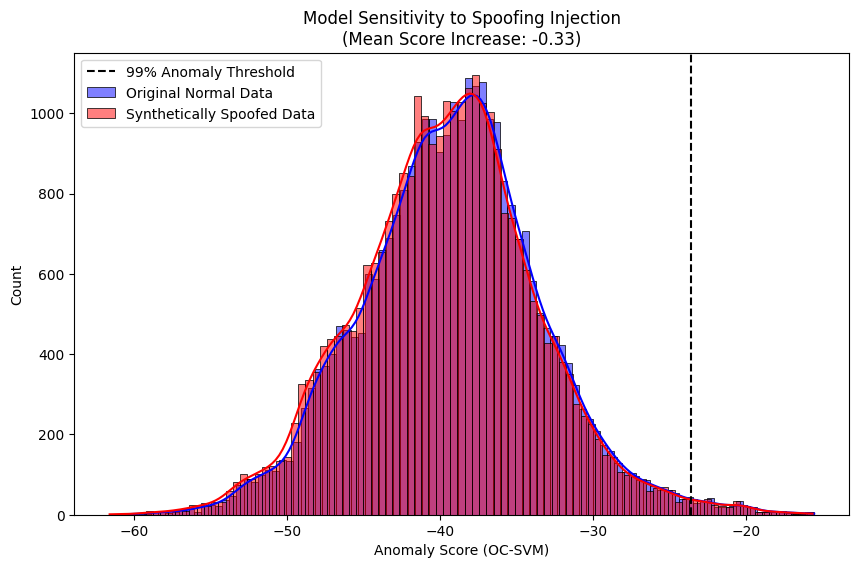

Spoofing Detection Rate: 0.94% of attacks were caught.


(array([-28.60945269, -28.81887691, -28.43804077, ..., -34.69394134,
        -34.3322083 , -35.08465901], shape=(29993,)),
 array([-29.03983726, -29.22010732, -28.90617576, ..., -35.0460064 ,
        -34.5995405 , -35.37152854], shape=(29993,)))

In [ ]:
def test_transformer_sensitivity(pipeline, delta_ticks=5, intensity_increase=1.0):
    """
    Tests if the Transformer + OC-SVM anomaly score spikes when a synthetic spoofing pattern is injected.
    """
    print(f"Running Sensitivity Test (Dist={delta_ticks}, Intensity={intensity_increase})...")
    
    pipeline.model.eval()
    
    # Identify Hawkes Intensity Features
    hawkes_indices = [i for i, c in enumerate(pipeline.feature_names) if 'Hawkes' in c or 'count' in c]
    if not hawkes_indices:
        print("Warning: No Hawkes/Count features found. Injecting noise on all features instead.")
        hawkes_indices = list(range(len(pipeline.feature_names)))

    # Select a subset of Normal data to test on: turn Normal data into Anomalies
    X_test_tensor = torch.tensor(pipeline.X_test, dtype=torch.float32).to(pipeline.device)
    
    # Get Baseline Scores 
    z_base = pipeline._get_latent(pipeline.X_test)
    z_base_scaled = pipeline.latent_scaler.transform(z_base)
    base_scores = -pipeline.detector.score_samples(z_base_scaled) # High = Anomaly

    # Create Spoofed Data
    # Pattern: Suddenly increase order intensity (Hawkes) at the last timestep
    X_spoofed = X_test_tensor.clone()
    X_spoofed[:, -1, hawkes_indices] += intensity_increase
    
    # New Scores
    z_spoof = pipeline._get_latent(X_spoofed.cpu().numpy())
    z_spoof_scaled = pipeline.latent_scaler.transform(z_spoof)
    spoof_scores = -pipeline.detector.score_samples(z_spoof_scaled)

    # Comparison
    score_diff = spoof_scores - base_scores
    
    # Results
    plt.figure(figsize=(10, 6))
    sns.histplot(base_scores, color='blue', alpha=0.5, label='Original Normal Data', kde=True)
    sns.histplot(spoof_scores, color='red', alpha=0.5, label='Synthetically Spoofed Data', kde=True)
    
    plt.axvline(np.percentile(base_scores, 99), color='black', linestyle='--', label='99% Anomaly Threshold')
    
    plt.title(f"Model Sensitivity to Spoofing Injection\n(Mean Score Increase: {np.mean(score_diff):.2f})")
    plt.xlabel("Anomaly Score (OC-SVM)")
    plt.legend()
    plt.show()

    # Success Metric: Percentage of normal samples that crossed the threshold
    threshold = np.percentile(base_scores, 99)
    detection_rate = np.mean(spoof_scores > threshold) * 100
    print(f"Spoofing Detection Rate: {detection_rate:.2f}% of attacks were caught.")
    
    return base_scores, spoof_scores

test_transformer_sensitivity(pipeline)

--- DIAGNOSTIC MODE ---
Injection Successful on feature 'bid-volume-1'
Normal Max Vol: -2.1384
Spoof Max Vol:  2.8616 (Should be ~5.0+)

--- SCORE BREAKDOWN ---
Reconstruction Error (MSE) - Normal: 0.086881
Reconstruction Error (MSE) - Spoof:  0.097855
  -> Ratio (Spoof/Normal): 1.13x
Latent Distance - Normal: 84.4482
Latent Distance - Spoof:  84.7863
  -> Ratio (Spoof/Normal): 1.00x


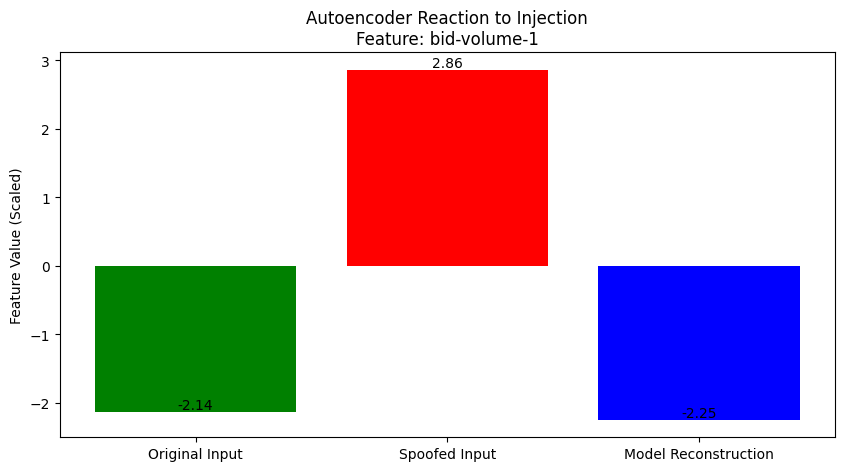

In [ ]:
def debug_model_vision(pipeline):
    # Create the spoof
    X_normal = pipeline.X_test[:10].copy() # Take just 10 samples
    X_spoof = X_normal.copy()
    
    # Inject Massive Volume
    vol_idx = pipeline.feature_names.index('bid-volume-1')
    X_spoof[:, -1, vol_idx] += 5.0 
    print(f"Injection Successful on feature '{pipeline.feature_names[vol_idx]}'")


    # Check Max values
    print(f"Normal Max Vol: {X_normal[:, -1, vol_idx].max():.4f}")
    print(f"Spoof Max Vol:  {X_spoof[:, -1, vol_idx].max():.4f} (Should be ~5.0+)")

    # Compare Model Reaction (Input vs Output)
    pipeline.model.eval()
    tensor_spoof = torch.tensor(X_spoof, dtype=torch.float32).to(pipeline.device)
    
    with torch.no_grad():
        recon_spoof = pipeline.model(tensor_spoof).cpu().numpy()
        
        z_spoof = pipeline._get_latent(X_spoof)
        z_normal = pipeline._get_latent(X_normal)


    # MSE
    mse_normal = np.mean((X_normal - pipeline.model(torch.tensor(X_normal, dtype=torch.float32).to(pipeline.device)).detach().cpu().numpy())**2)
    mse_spoof = np.mean((X_spoof - recon_spoof)**2)
    
    # Latent Distance
    center = np.mean(z_normal, axis=0)
    dist_normal = np.linalg.norm(z_normal - center)
    dist_spoof = np.linalg.norm(z_spoof - center)

    print(f"Reconstruction Error (MSE) - Normal: {mse_normal:.6f}")
    print(f"Reconstruction Error (MSE) - Spoof:  {mse_spoof:.6f}")
    print(f"Ratio (Spoof/Normal): {mse_spoof/mse_normal:.2f}x")
    
    print(f"Latent Distance - Normal: {dist_normal:.4f}")
    print(f"Latent Distance - Spoof:  {dist_spoof:.4f}")
    print(f"Ratio (Spoof/Normal): {dist_spoof/dist_normal:.2f}x")

    plt.figure(figsize=(10, 5))
    
    feat_idx = vol_idx
    
    indices = np.arange(3)
    values = [
        X_normal[0, -1, feat_idx],   # Original
        X_spoof[0, -1, feat_idx],    # Injected
        recon_spoof[0, -1, feat_idx] # Model Output
    ]
    
    bars = plt.bar(indices, values, color=['green', 'red', 'blue'])
    plt.xticks(indices, ['Original Input', 'Spoofed Input', 'Model Reconstruction'])
    plt.ylabel('Feature Value (Scaled)')
    plt.title(f'Autoencoder Reaction to Injection\nFeature: {pipeline.feature_names[feat_idx]}')
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
        
    plt.show()

debug_model_vision(pipeline)

Running Coherent Spoofing Sensitivity Test...
Detection Rate with Hybrid Score + Coherent Injection: 1.02%


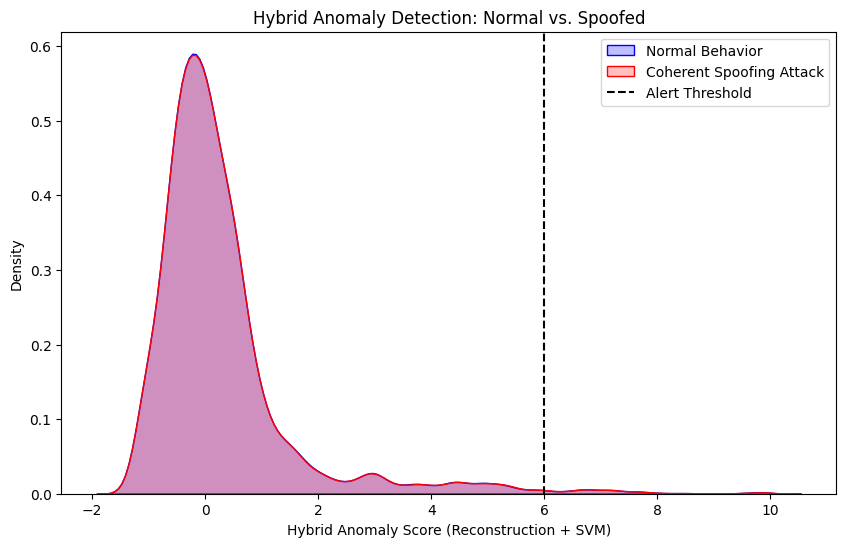

In [30]:
def compute_hybrid_score(pipeline, X, alpha=0.9): # Changed alpha to 0.9 (mostly MSE)
    """
    Combines Reconstruction Error (MSE) with Latent Outlier Score (SVM).
    High Alpha = Rely on Reconstruction Error (good for 'denoised' attacks).
    Low Alpha = Rely on Latent Space (good for 'weird shape' attacks).
    """
    pipeline.model.eval()
    dataset = torch.tensor(X, dtype=torch.float32).to(pipeline.device)
    loader = torch.utils.data.DataLoader(dataset, batch_size=pipeline.batch_size, shuffle=False)
    
    recon_errors = []
    
    with torch.no_grad():
        for batch in loader:
            inputs = batch.to(pipeline.device)
            outputs = pipeline.model(inputs)
            
            # MSE: Mean Squared Error per sequence
            # We explicitly sum over features to capture the magnitude of the spike
            mse = torch.mean((inputs - outputs) ** 2, dim=(1, 2))
            recon_errors.append(mse.cpu().numpy())
            
    recon_scores = np.concatenate(recon_errors)

    # Calculate SVM scores (for completeness)
    z = pipeline._get_latent(X)
    z_scaled = pipeline.latent_scaler.transform(z)
    svm_scores = -pipeline.detector.score_samples(z_scaled)
    
    # Robust Normalization (Crucial!)
    # We use Median and IQR because the "Spoof" MSE might be an outlier
    def robust_scale(arr):
        median = np.median(arr)
        iqr = np.percentile(arr, 75) - np.percentile(arr, 25)
        return (arr - median) / (iqr + 1e-9)

    norm_recon = robust_scale(recon_scores)
    norm_svm = robust_scale(svm_scores)
    
    # Combine
    hybrid_scores = alpha * norm_recon + (1 - alpha) * norm_svm
    
    return hybrid_scores, recon_scores, svm_scores


def test_coherent_spoofing(pipeline):
    print("Running Coherent Spoofing Sensitivity Test...")
    
    # Identify indices
    try:
        idx_vol = pipeline.feature_names.index('bid-volume-1') # Assuming bid-side spoof
        idx_imb = [i for i, c in enumerate(pipeline.feature_names) if 'Weighted_Imbalance' in c]
        idx_hawkes = [i for i, c in enumerate(pipeline.feature_names) if 'Hawkes' in c]
    except ValueError:
        print("Required features missing. Ensure 'base', 'tao', and 'hawkes' sets are engineered.")
        return

    # 1. Baseline Scores (Hybrid)
    base_hybrid, _, _ = compute_hybrid_score(pipeline, pipeline.X_test)
    
    # 2. Create Coherent Attack
    # We take the normal test set and inject a massive spoof at the last timestep
    X_spoof = pipeline.X_test.copy()
    
    # ACTION: Massive Volume Injection (+5 Std Devs)
    # Since data is MinMax scaled (0-1), adding 1.0 is a massive jump (100% of range)
    X_spoof[:, -1, idx_vol] += 1.0 
    
    # ACTION: Imbalance Shift (Spoofing makes the book look heavy on one side)
    X_spoof[:, -1, idx_imb] += 1.0
    
    # ACTION: Intensity Spike (High frequency activity)
    X_spoof[:, -1, idx_hawkes] += 0.5

    # 3. Spoofed Scores (Hybrid)
    spoof_hybrid, _, _ = compute_hybrid_score(pipeline, X_spoof)
    
    # 4. Check Detection Rate
    threshold = np.percentile(base_hybrid, 99) # 1% False Positive Rate
    detection_rate = np.mean(spoof_hybrid > threshold) * 100
    
    print(f"Detection Rate with Hybrid Score + Coherent Injection: {detection_rate:.2f}%")
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.kdeplot(base_hybrid, fill=True, label='Normal Behavior', color='blue')
    sns.kdeplot(spoof_hybrid, fill=True, label='Coherent Spoofing Attack', color='red')
    plt.axvline(threshold, color='k', linestyle='--', label='Alert Threshold')
    plt.title("Hybrid Anomaly Detection: Normal vs. Spoofed")
    plt.xlabel("Hybrid Anomaly Score (Reconstruction + SVM)")
    plt.legend()
    plt.show()

# Run the improved test
test_coherent_spoofing(pipeline)

Testing MSE Separation Power...
MSE-based Detection Rate at 99% Threshold: 1.04%


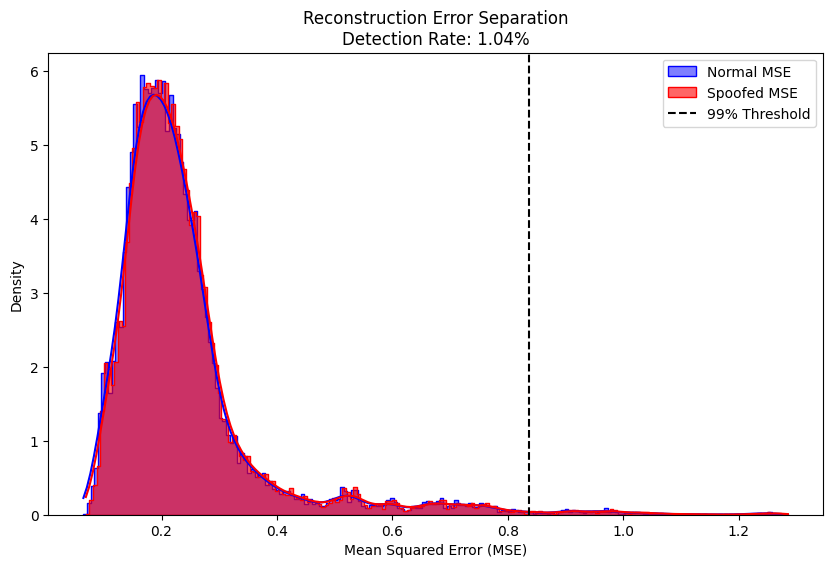

In [ ]:
def test_mse_separation(pipeline):
    print("Testing MSE Separation Power...")
    
    # Get Normal MSE
    _, mse_normal, _ = compute_hybrid_score(pipeline, pipeline.X_test, alpha=1.0)
    
    # Create Coherent Spoof
    X_spoof = pipeline.X_test.copy()
    try:
        vol_idx = pipeline.feature_names.index('bid-volume-1')
        X_spoof[:, -1, vol_idx] += 3.0
    except:
        pass

    # Get Spoof MSE
    _, mse_spoof, _ = compute_hybrid_score(pipeline, X_spoof, alpha=1.0)
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.histplot(mse_normal, color='blue', label='Normal MSE', kde=True, stat="density", element="step")
    sns.histplot(mse_spoof, color='red', label='Spoofed MSE', kde=True, stat="density", element="step", alpha=0.6)
    
    # Calculate overlap
    threshold = np.percentile(mse_normal, 99)
    detection_rate = np.mean(mse_spoof > threshold) * 100
    print(f"MSE-based Detection Rate at 99% Threshold: {detection_rate:.2f}%")
    plt.axvline(threshold, color='black', linestyle='--', label='99% Threshold')
    plt.title(f"Reconstruction Error Separation\nDetection Rate: {detection_rate:.2f}%")
    plt.xlabel("Mean Squared Error (MSE)")
    plt.legend()
    plt.show()

test_mse_separation(pipeline)

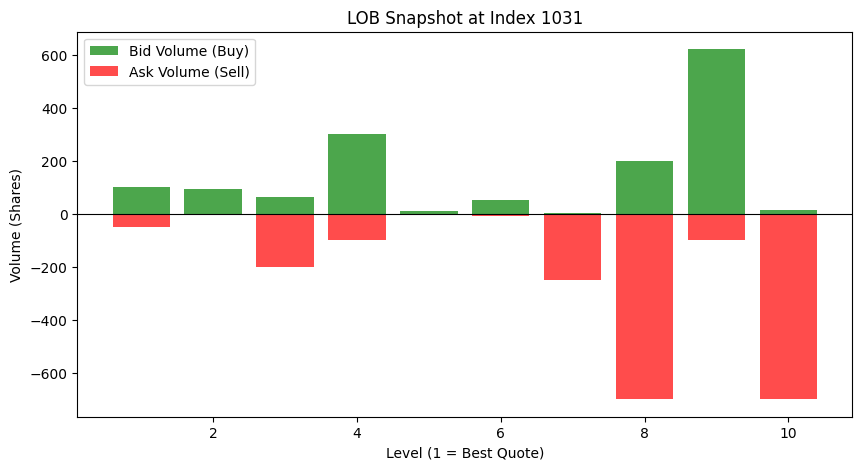

In [23]:
def plot_lob_snapshot(pipeline, index, levels=10):
    """Visualizes the Order Book shape at a specific index."""
    row = pipeline.raw_df.iloc[index]
    
    bids = [row[f'bid-volume-{i}'] for i in range(1, levels+1)]
    asks = [row[f'ask-volume-{i}'] for i in range(1, levels+1)]
    
    # Levels (1 to 10)
    x = np.arange(1, levels+1)
    
    plt.figure(figsize=(10, 5))
    plt.bar(x, bids, color='green', label='Bid Volume (Buy)', alpha=0.7)
    plt.bar(x, [-a for a in asks], color='red', label='Ask Volume (Sell)', alpha=0.7) # Negative for visual contrast
    
    plt.axhline(0, color='black', linewidth=0.8)
    plt.xlabel("Level (1 = Best Quote)")
    plt.ylabel("Volume (Shares)")
    plt.title(f"LOB Snapshot at Index {index}")
    plt.legend()
    plt.show()

# Visualize the top anomaly
# (You can get the index from your previous analysis function)
plot_lob_snapshot(pipeline, index=top_anomaly_idx)

Visualizing evolution around index 1031 with offset 1...


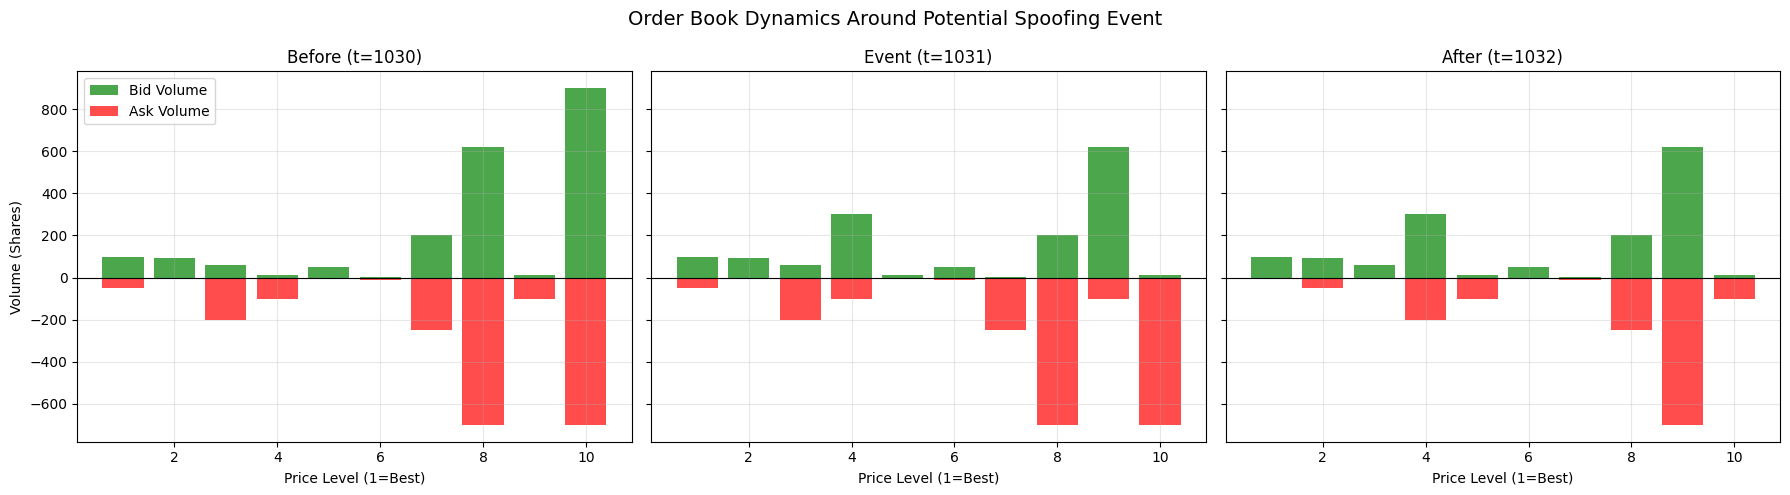

In [ ]:
def plot_lob_evolution(pipeline, center_index, offset=10, levels=10):
    """
    Plots LOB snapshots before, during, and after a specific index.
    
    Args:
        center_index: The time index of the detected anomaly.
        offset: Number of time steps to look before/after.
        levels: Number of price levels to display.
    """
    indices = [center_index - offset, center_index, center_index + offset]
    titles = [f"Before (t={center_index - offset})", 
              f"Event (t={center_index})", 
              f"After (t={center_index + offset})"]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    x = np.arange(1, levels + 1)
    
    for i, idx in enumerate(indices):
        if 0 <= idx < len(pipeline.raw_df):
            row = pipeline.raw_df.iloc[idx]
            
            # Extract volumes
            bids = [row[f'bid-volume-{l}'] for l in range(1, levels+1)]
            asks = [row[f'ask-volume-{l}'] for l in range(1, levels+1)]
            
            # Plot Bid vs Ask
            axes[i].bar(x, bids, color='green', label='Bid Volume' if i==0 else "", alpha=0.7)
            axes[i].bar(x, [-a for a in asks], color='red', label='Ask Volume' if i==0 else "", alpha=0.7)
            
            axes[i].axhline(0, color='black', linewidth=0.8)
            axes[i].set_title(titles[i])
            axes[i].set_xlabel("Price Level (1=Best)")
            axes[i].grid(True, alpha=0.3)
            
            if i == 0:
                axes[i].set_ylabel("Volume (Shares)")
                axes[i].legend()
        else:
            axes[i].text(0.5, 0.5, "Index Out of Bounds", ha='center')

    plt.suptitle(f"Order Book Dynamics Around Potential Spoofing Event", fontsize=14)
    plt.tight_layout()
    plt.show()


offset = 1
print(f"Visualizing evolution around index {top_anomaly_idx} with offset {offset}...")
plot_lob_evolution(pipeline, top_anomaly_idx, offset=offset)